In [1]:
# import packages
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model

from keras.utils import to_categorical
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Flatten, Activation, Input, BatchNormalization

In [2]:
def detect_face(img):
  face_cascade = cv2.CascadeClassifier('../utils/haarcascade_frontalface_default.xml')
  
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  
  if len(faces) == 0:
      return None
  
  # Get the first detection face - can choose random
  x, y, w, h = faces[0]
  
  # Crop the face from the image
  face = img[y:y+h, x:x+w]
  
  face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  
  face_resized = cv2.resize(face_gray, (50, 50))
  
  return face_resized

In [4]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [34]:
dataset_folder = "../../../dataset/data/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img)
            if img is not None :
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (50 samples)	 label : Akshay Kumar 		
[####################] (74 samples)	 label : Amitabh Bachchan 				
[####################] (92 samples)	 label : Andy Samberg 		
[####################] (98 samples)	 label : Billie Eilish 			
[####################] (120 samples)	 label : Brad Pitt 		
[####################] (87 samples)	 label : Camila Cabello 		
[####################] (78 samples)	 label : Charlize Theron 		
[####################] (96 samples)	 label : Claire Holt 		
[####################] (80 samples)	 label : Courtney Cox 		
[####################] (61 samples)	 label : Dwayne Johnson 		
[####################] (71 samples)	 label : Elizabeth Olsen 		
[####################] (75 samples)	 label : Ellen Degeneres 		
[####################] (106 samples)	 label : Henry Cavill 		
[####################] (101 samples)	 label : Hrithik Roshan 		
[####################] (112 samples)	 label : Hugh Jackman 		
[####################] (108 samples)	 label : Jessica Alba 		

In [37]:
print("number of samples :", len(images) + 92 + 79 + 67 + 29 + 31 + 48)

number of samples : 2774


In [7]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

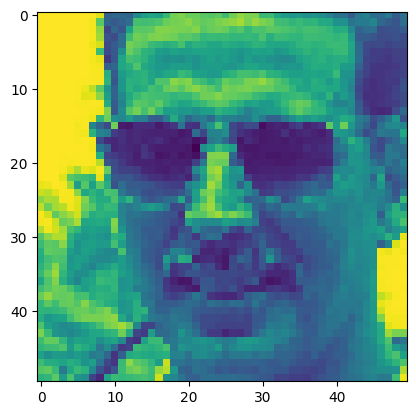

In [8]:
plt.imshow(images[0])

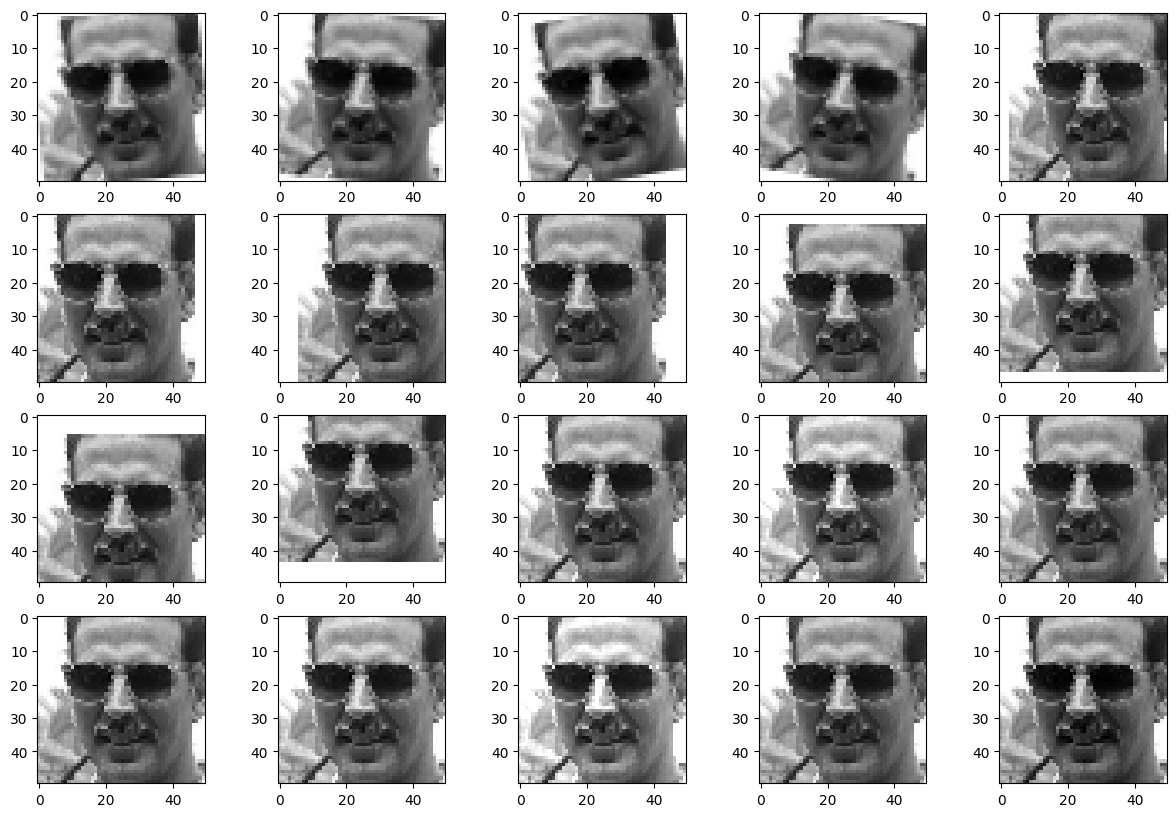

In [9]:
img_test = images[0]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [10]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

In [11]:
len(augmented_images), len(augmented_names)

(48600, 48600)

In [12]:
images.extend(augmented_images)
names.extend(augmented_names)

In [13]:
len(images), len(names)

(51030, 51030)

In [14]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Akshay Kumar', 1050)
('Alexandra Daddario', 1932)
('Alia Bhatt', 1596)
('Amitabh Bachchan', 1491)
('Andy Samberg', 1932)
('Anushka Sharma', 1386)
('Billie Eilish', 1785)
('Brad Pitt', 2499)
('Camila Cabello', 1722)
('Charlize Theron', 1617)
('Claire Holt', 1995)
('Courtney Cox', 1680)
('Dwayne Johnson', 1281)
('Elizabeth Olsen', 1470)
('Ellen Degeneres', 1575)
('Henry Cavill', 2205)
('Hrithik Roshan', 1890)
('Hugh Jackman', 2289)
('Jessica Alba', 2247)
('Lisa Kudrow', 1470)
('Margot Robbie', 1491)
('Natalie Portman', 2184)
('Priyanka Chopra', 2100)
('Robert Downey Jr', 2352)
('Roger Federer', 1407)
('Tom Cruise', 1197)
('Trung Tran', 1050)
('Vijay Deverakonda', 2268)
('Zac Efron', 1869)


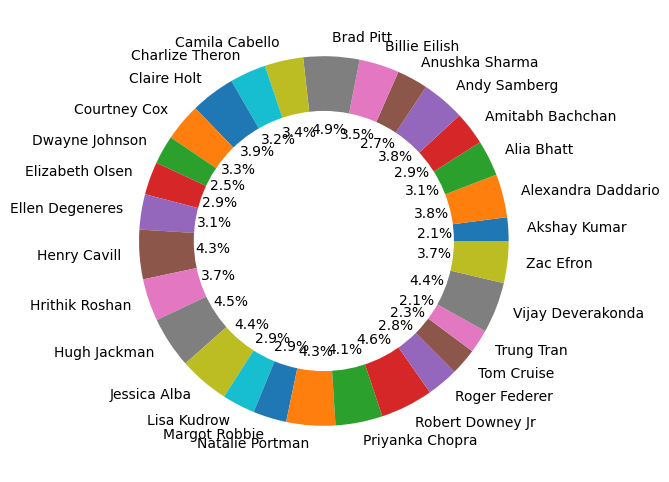

In [15]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [16]:
# reduce sample size per-class using numpy random choice
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [17]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

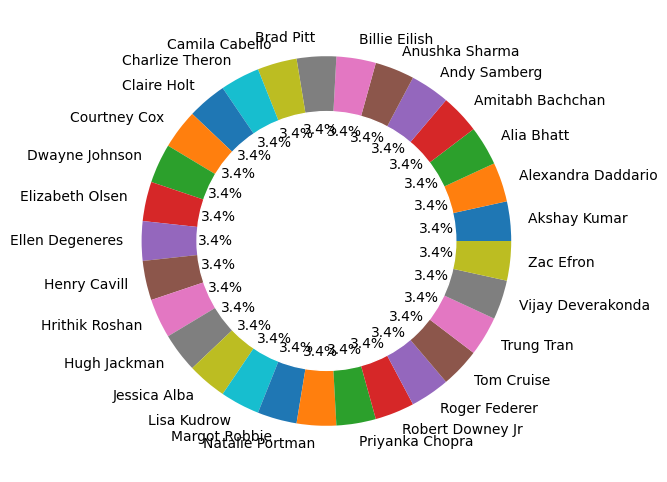

In [19]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [18]:
len(names)

29000

In [20]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [21]:
print("number of class :", len(labels))
print(labels)

number of class : 29
['Akshay Kumar' 'Alexandra Daddario' 'Alia Bhatt' 'Amitabh Bachchan'
 'Andy Samberg' 'Anushka Sharma' 'Billie Eilish' 'Brad Pitt'
 'Camila Cabello' 'Charlize Theron' 'Claire Holt' 'Courtney Cox'
 'Dwayne Johnson' 'Elizabeth Olsen' 'Ellen Degeneres' 'Henry Cavill'
 'Hrithik Roshan' 'Hugh Jackman' 'Jessica Alba' 'Lisa Kudrow'
 'Margot Robbie' 'Natalie Portman' 'Priyanka Chopra' 'Robert Downey Jr'
 'Roger Federer' 'Tom Cruise' 'Trung Tran' 'Vijay Deverakonda' 'Zac Efron']


In [22]:
print(name_vec)

[ 0  0  0 ... 28 28 28]


In [23]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
x_train.shape, x_test.shape

In [72]:
def build_cnn(input_shape):
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 4
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 5
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels), activation='softmax'))

    model.summary()

    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    return model

In [73]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = build_cnn(input_shape)

d:\Project\face-recognition\api\.env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)              │ (None, 50, 50, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 33,731,805 (128.68 MB)

 Trainable params: 33,723,357 (128.64 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [74]:
history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 607s 916ms/step - accuracy: 0.1210 - loss: 3.3517 - val_accuracy: 0.2423 - val_loss: 2.7603
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 545s 833ms/step - accuracy: 0.3833 - loss: 2.0344 - val_accuracy: 0.5065 - val_loss: 1.7385
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 564s 862ms/step - accuracy: 0.5517 - loss: 1.4992 - val_accuracy: 0.5211 - val_loss: 1.7161
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 579s 884ms/step - accuracy: 0.6887 - loss: 1.0827 - val_accuracy: 0.5595 - val_loss: 1.5453
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.7554 - loss: 0.8735 - val_accuracy: 0.7512 - val_loss: 0.8850
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 635s 970ms/step - accuracy: 0.8072 - loss: 0.7022 - val_accuracy: 0.7683 - val_loss: 0.8572
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 541s 825ms/step - accuracy: 0.8331 - loss: 0.6170 - val_accuracy: 0.8156 - val_loss: 0.6499
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 561s 857ms/step - accuracy: 0.8482 - lo

In [75]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

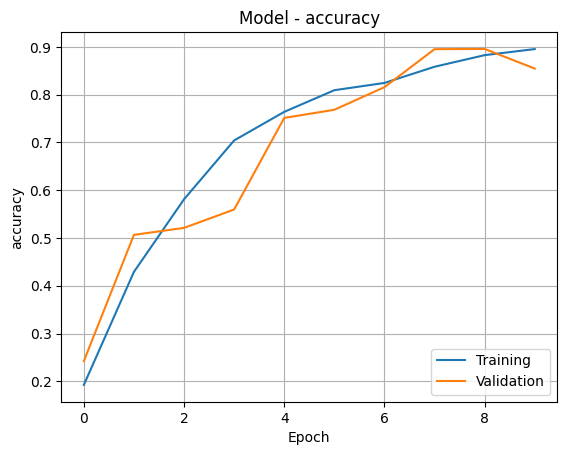

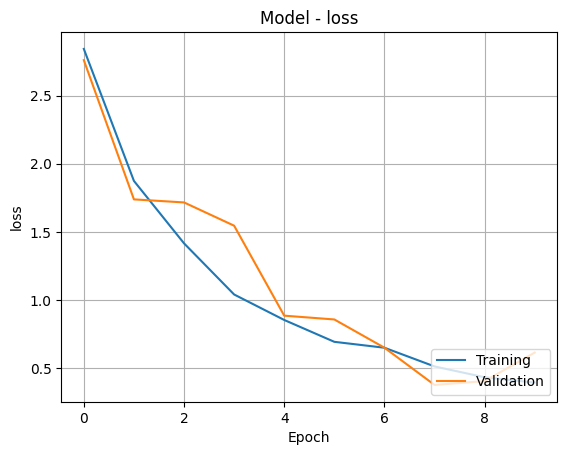

In [76]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names:
        fig, ax = plt.subplots()
        ax.plot(history.history[name[0]])
        ax.plot(history.history[name[1]])
        ax.set(xlabel='Epoch', ylabel=name[0])
        ax.set_title('Model - ' + name[0])
        ax.legend(['Training', 'Validation'], loc='lower right')
        ax.grid()
        plt.show()

evaluate_model_(history)

In [77]:
model.save("../model/20240619-model.h5")

In [78]:
# predict test data
y_pred=model.predict(x_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step


In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

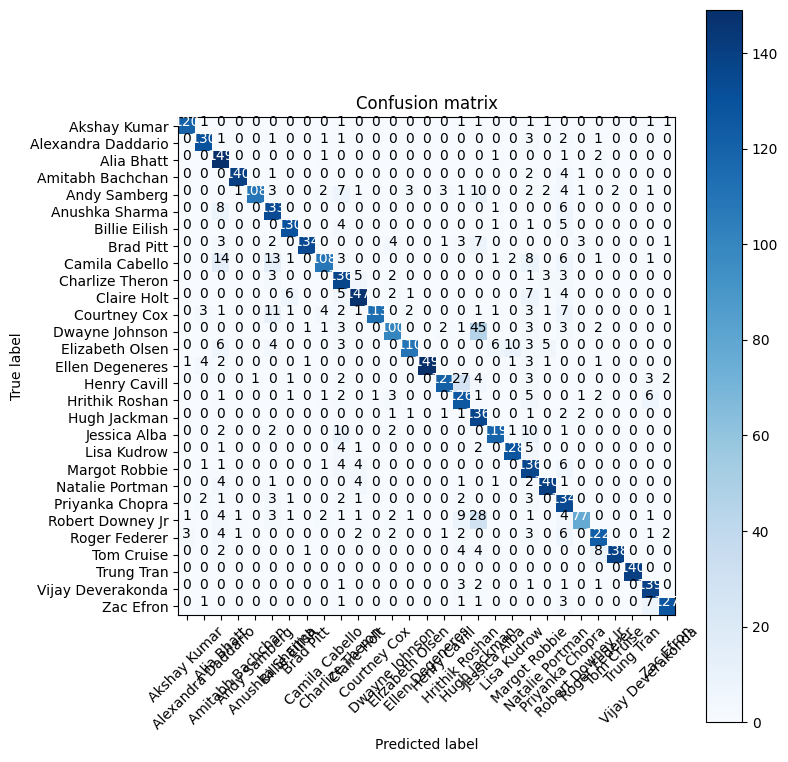

In [80]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')

In [81]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                    precision    recall  f1-score   support

      Akshay Kumar       0.96      0.94      0.95       128
Alexandra Daddario       0.92      0.93      0.92       140
        Alia Bhatt       0.73      0.97      0.83       154
  Amitabh Bachchan       0.98      0.95      0.96       148
      Andy Samberg       0.99      0.72      0.83       151
    Anushka Sharma       0.74      0.90      0.81       148
     Billie Eilish       0.92      0.92      0.92       141
         Brad Pitt       0.98      0.85      0.91       158
    Camila Cabello       0.89      0.68      0.77       158
   Charlize Theron       0.71      0.89      0.79       153
       Claire Holt       0.88      0.85      0.86       173
      Courtney Cox       0.99      0.74      0.85       152
    Dwayne Johnson       0.85      0.62      0.72       161
   Elizabeth Olsen       0.93      0.75      0.83       147
   Ellen Degeneres       1.00      0.91      0.96       163
      Henry Cavill       0.94      0.74

In [26]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [24]:
from keras.models import load_model

In [28]:
# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('../utils/haarcascade_frontalface_default.xml')

# --------- load Keras CNN model -------------
model = load_model("../model/20240619-model.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 80:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Detect Face', frame)
    else : 
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_1144\443885494.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_text = "%s (%.2f %%)" % (labels[idx], confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━